# Exploratory Data Analysis 

## Introduction

## Imports

In [1]:
## Import libraries and packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import warnings

## Load Dataset

In [2]:
# Load data into a pandas DataFrame

data1 = pd.read_csv('housingdata.csv')

In [3]:
data1.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,140499.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN


In [4]:
print(data1.shape)

(526989, 12)


In [5]:
# Convert brokered_by, street, and zip_code columns into strings
data1['brokered_by'] = data1['brokered_by'].astype(str)
data1['street'] = data1['street'].astype(str)
data1['zip_code'] = data1['zip_code'].astype(str)

In [6]:
# Remove trailing zero
data1['brokered_by'] = data1['brokered_by'].str.rstrip('.0')
data1['street'] = data1['street'].str.rstrip('.0')
data1['zip_code'] = data1['zip_code'].str.rstrip('.0')

In [7]:
# Convert bed column to an integer
data1['bed'] = data1['bed'].astype(int)

In [8]:
data1.info()
data1.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526989 entries, 0 to 526988
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brokered_by     526989 non-null  object 
 1   status          526989 non-null  object 
 2   price           526625 non-null  float64
 3   bed             526989 non-null  int32  
 4   bath            526989 non-null  float64
 5   acre_lot        526989 non-null  float64
 6   street          526989 non-null  object 
 7   city            526878 non-null  object 
 8   state           526989 non-null  object 
 9   zip_code        526989 non-null  object 
 10  house_size      526989 non-null  float64
 11  prev_sold_date  329991 non-null  object 
dtypes: float64(4), int32(1), object(7)
memory usage: 46.2+ MB


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378,for_sale,105000.0,3,2.0,0.12,1962661,Adjuntas,Puerto Rico,601,920.0,NaN
1,52707,for_sale,80000.0,4,2.0,0.08,1902874,Adjuntas,Puerto Rico,601,1527.0,NaN
2,103379,for_sale,67000.0,2,1.0,0.15,140499,Juana Diaz,Puerto Rico,795,748.0,NaN


<Axes: >

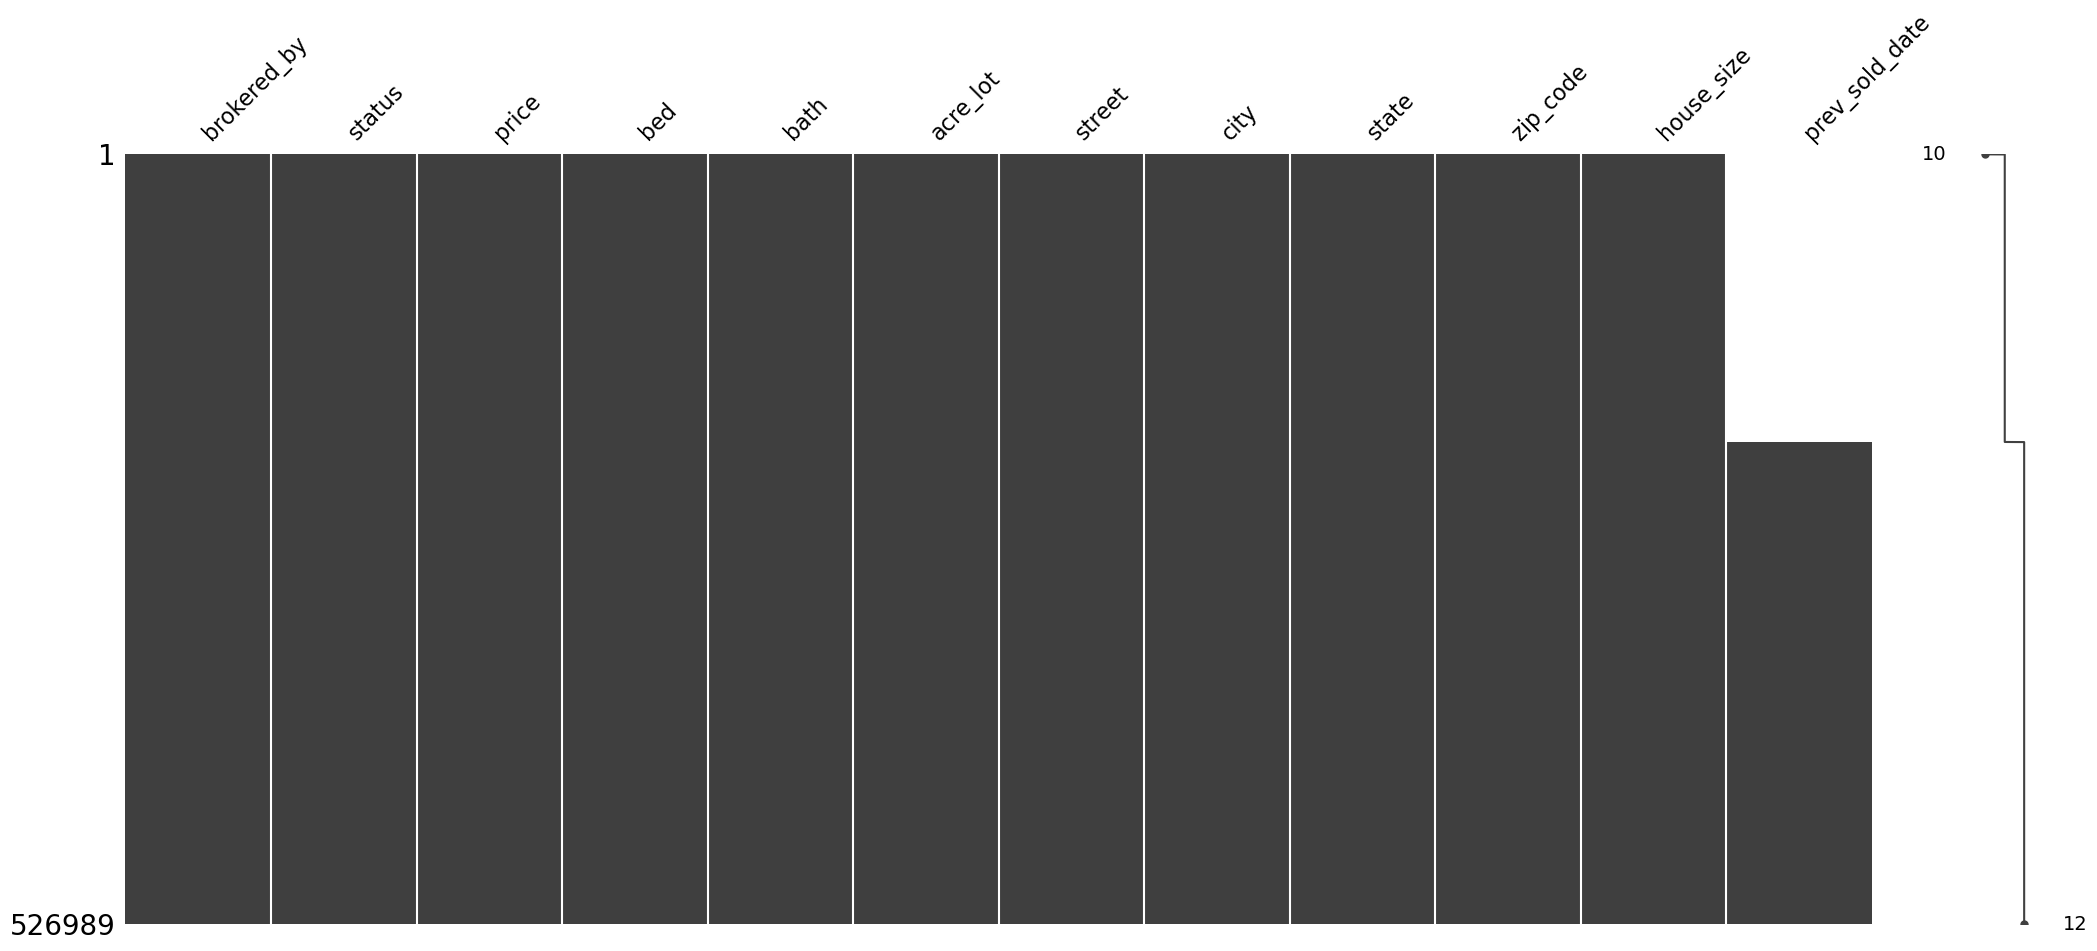

In [9]:
# Visualizing null values
msno.matrix(data1, sort='ascending')

In [10]:
# Check for missing values in each column
print("\nMissing values in each column:")
print(data1.isna().sum())


Missing values in each column:
brokered_by            0
status                 0
price                364
bed                    0
bath                   0
acre_lot               0
street                 0
city                 111
state                  0
zip_code               0
house_size             0
prev_sold_date    196998
dtype: int64


## Outliers

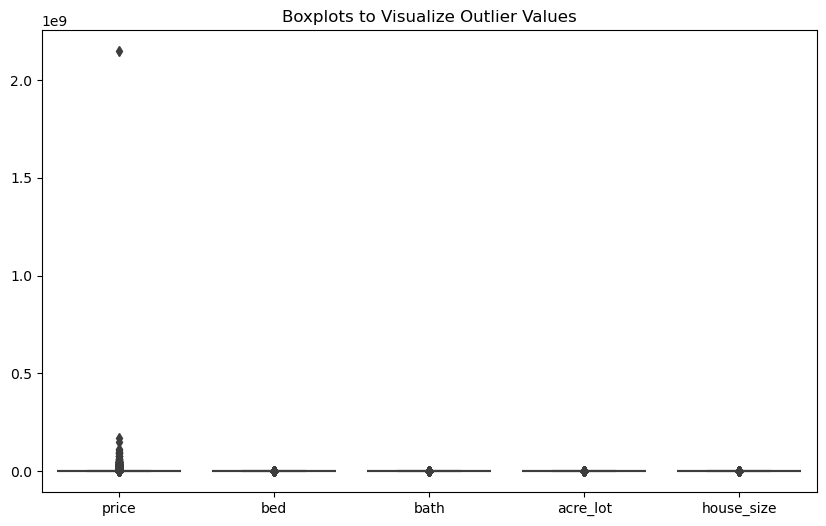

In [11]:
# Create box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=data1)
plt.title('Boxplots to Visualize Outlier Values')
plt.show();

In [12]:
# Maximun value in price column
max_price = data1['price'].max()
print(f"Maximum value of a house in price is:", {max_price})

Maximum value of a house in price is: {2147483600.0}


The maximum price appears to be extremely high at $2147483600.00, probably an error in typing. Let's drop this price.

In [13]:
data1 = data1[data1['price'] != max_price]

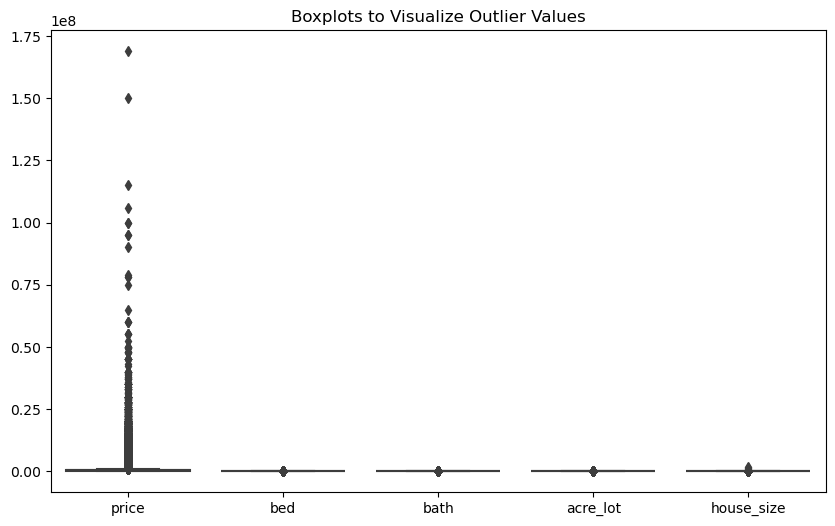

In [14]:
# Create box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=data1)
plt.title('Boxplots to Visualize Outlier Values')
plt.show();

C:\Users\MTIDES\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


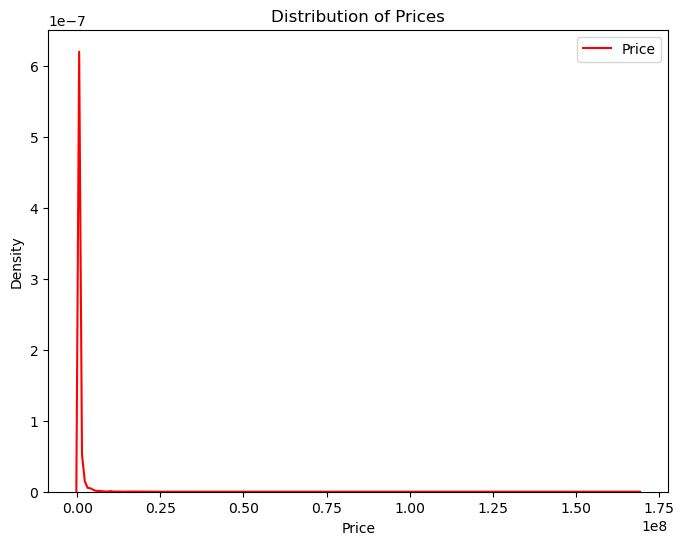

In [15]:
# A density plot (KDE) of the 'price' column
plt.figure(figsize=(8, 6))
sns.kdeplot(data1['price'], fill=False, color='r', label='Price')

# Labels and title
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices')
plt.legend()

# Display
plt.show();